# Plots

In [2]:
import numpy as np
import math
import sys
import os
import itertools
import time
from tqdm import tqdm
from IPython.display import display, HTML
from scipy import stats
from scipy.sparse import csr_matrix
from scipy import special
from scipy.stats import gaussian_kde
from numpy.linalg import cholesky
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import splu
src_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))
sys.path.append(src_path)
from forest_v2 import RegressionTreeModel
from forest_v2 import RandomForestModel
from forest_v2 import HistogramEstimator
import functions as fcts

In [3]:
# Regression model
# dimension of the feature space
p = 2

#regression function
regression_fct=fcts.m_p2_01

The section below is used to approximate the quantiles necessary for the CPRF confidence bands. The quantiles for the histogram is below this section. 

# Covariances and estimation of the distribution of the supremum for RF CBs

In [10]:
# depth of the trees
k = 5 #5,6

# smaller k for evaluation grid (choice justified later)
k2 = 4 #4,5

#Ehrenfest parameters
B = 12
delta = 7
np.set_printoptions(suppress=True)

In [4]:
# estimation of all possible covariance entries using the parameters for the partition construction
np.random.seed(0)
n_parts=50000 # number of split pairs generated
comb_list=[]
for com in itertools.combinations_with_replacement(range(0, k + 1), p):
    comb_list.append(com)
combs=np.array(comb_list)

cu_vol=np.zeros(len(combs))
for j in range(n_parts):
    s1=np.bincount(np.random.choice(p, k, replace=True),minlength=p)
    s2=np.bincount(np.random.choice(p, k, replace=True),minlength=p)
    for i in range(len(combs)):
        cu_vol[i]+=fcts.vol_intersec_2(combs[i],s1,s2)
av_vol=cu_vol/n_parts

V_cap_uni=av_vol[len(av_vol)-1]
cov_entries_uni=av_vol/V_cap_uni

cu_vol=np.zeros(len(combs))
for j in range(n_parts):
    s1=fcts.ehr_splits(np.zeros(p),np.ones(p)*B,delta,k)
    s2=fcts.ehr_splits(np.zeros(p),np.ones(p)*B,delta,k)
    for i in range(len(combs)):
        cu_vol[i]+=fcts.vol_intersec_2(combs[i],s1,s2)
av_vol=cu_vol/n_parts

V_cap_ehr=av_vol[len(av_vol)-1]
cov_entries_ehr=av_vol/V_cap_ehr

print("Uniform V_cap:", V_cap_uni,", Ehrenfest V_cap:", V_cap_ehr,", 2^-k:", 1/2**k,", 2^-2k:",1/2**(2*k))

#cov_entries_ehr, cov_entries_uni, #len(cov_entries_uni),special.binom(k+p,p)

Uniform V_cap: 0.0163240625 , Ehrenfest V_cap: 0.017990234375 , 2^-k: 0.03125 , 2^-2k: 0.0009765625


Justification for the choice of $k_2$. For any pair of points in the feature space with closeness $(k_2,k_2)$ or larger, the Gaussian process' covariance should be close to one.

In [5]:
min_prob=0.99 # 0.9
print("Smallest closeness with cov > min_prob, Ehr.:",comb_list[np.argmax(cov_entries_ehr>min_prob)], "and Uni:", comb_list[np.argmax(cov_entries_uni>min_prob)])
print("Corresponding covariances: ", cov_entries_ehr[np.argmax(cov_entries_ehr>min_prob)], "and",cov_entries_uni[np.argmax(cov_entries_uni>min_prob)])

Smallest closeness with cov > min_prob, Ehr.: (4, 4) and Uni: (4, 4)
Corresponding covariances:  0.9993746607317338 and 0.9964775925110555


In [6]:
min_prob=0.99 # 0.9
print("Smallest closeness with cov > min_prob, Ehr.:",comb_list[np.argmax(cov_entries_ehr>min_prob)], "and Uni:", comb_list[np.argmax(cov_entries_uni>min_prob)])
print("Corresponding covariances: ", cov_entries_ehr[np.argmax(cov_entries_ehr>min_prob)], "and",cov_entries_uni[np.argmax(cov_entries_uni>min_prob)])

Smallest closeness with cov > min_prob, Ehr.: (4, 4) and Uni: (4, 4)
Corresponding covariances:  0.9993746607317338 and 0.9964775925110555


In [7]:
#k2=4
# Filling in the covariance entries in the matrices
X_test=fcts.test_grid(p,k2)
start_time = time.time()
X_test_M=np.array(list(itertools.product(X_test, repeat=2)))#.reshape((2**(k2*p),2**(k2*p),2,2))
X_test_V=X_test_M.reshape(2**(k2*p*2),2*p)
t_values=np.arange(0,k+1)
v_t=(2**t_values).reshape(-1,1)
fin_com_cell=np.empty((2**(k2*p*2),p))
for i in range(p):
    X_temp_1=X_test_V[:,i].reshape(-1,1)
    X_temp_2=X_test_V[:,i+p].reshape(-1,1)
    ints1=np.dot(X_temp_1,v_t.T).astype(int)
    ints2=np.dot(X_temp_2,v_t.T).astype(int)
    equal_mask=ints1==ints2
    fin_com_cell[:,i] = np.max(np.where(equal_mask, t_values, -np.inf),axis=1)
M=fin_com_cell.astype(int)
M=np.sort(M,axis=1)
M_int=np.sum(M*10**np.arange(p-1,-1,-1),axis=1)
int_combs=np.sum(combs*10**np.arange(p-1,-1,-1),axis=1)
indices = np.searchsorted(int_combs, M_int)
cov_uni=cov_entries_uni[indices].reshape((2**(k2*p),2**(k2*p)))
cov_ehr=cov_entries_ehr[indices].reshape((2**(k2*p),2**(k2*p)))
end_time = time.time()
print(f"Laufzeit: {end_time - start_time} Sekunden")
print("Size of the cov matrix: ",cov_uni.shape) #, np.info(cov_uni), np.info(cov_ehr)

Laufzeit: 0.09114718437194824 Sekunden
Size of the cov matrix:  (256, 256)


The next two cells perform the Cholesky decomposition of the covariance matrices. If this is not possible due to the estimation error, they reconstruct the matrix beforehand. Either based on all eigenvalues larger than $\epsilon$ and their corresponding eigenvectors or based on the SVD. 

In [8]:
epsilon=1e-6
try:
    L_uni = cholesky(cov_uni+epsilon * np.eye(2**(k2*p)))
except Exception as e:
    eig_values, eig_vectors = np.linalg.eigh(cov_uni)
    corrected_eig_values = np.maximum(eig_values, epsilon)
    fixed_cov_uni = eig_vectors @ np.diag(corrected_eig_values) @ eig_vectors.T
    L_uni = cholesky(fixed_cov_uni)
    print(f"An error occured: {e}.", "We used reconstruction of the covariance matrix via eigenvectors before the cholesky decomposition.")
else:
    print("We used the cholesky decomposition of the original covariance matrix.")
    
#stats.describe((L_uni @ L_uni.T)[:,0] -cov_uni[:,0])

An error occured: Matrix is not positive definite. We used reconstruction of the covariance matrix via eigenvectors before the cholesky decomposition.


In [9]:
epsilon=1e-6
try:
    L_ehr = cholesky(cov_ehr+epsilon * np.eye(2**(k2*p))) #+1e-3 * np.eye(2**(k*p))
except Exception as e:
    eig_values, eig_vectors = np.linalg.eigh(cov_ehr)
    corrected_eig_values = np.maximum(eig_values, epsilon)
    fixed_cov_ehr = eig_vectors @ np.diag(corrected_eig_values) @ eig_vectors.T
    L_ehr = cholesky(fixed_cov_ehr)
    print(f"An error occured: {e}.", "We used reconstruction of the covariance matrix via eigenvectors before the cholesky decomposition.")
else:
    print("We used the cholesky decomposition of the original covariance matrix.")

#stats.describe((L_ehr @ L_ehr.T)[:,0] -cov_ehr[:,0])

An error occured: Matrix is not positive definite. We used reconstruction of the covariance matrix via eigenvectors before the cholesky decomposition.


In [10]:
#Generating suprema of the Gaussian process to estimate the quantiles
np.random.seed(0)
sups_GP_uni=[]
sups_GP_ehr=[]
# number of suprema
n_sups=100000
for _ in range(n_sups):
    e=np.random.normal(0,1,2**(k2*p))
    gp_uni = L_uni @ e
    gp_ehr = L_ehr @ e
    sups_GP_uni.append(np.max(np.abs(gp_uni)))
    sups_GP_ehr.append(np.max(np.abs(gp_ehr)))

## Distribution for the histogram confidence bands

In [11]:
# number of grid cells per feature for the histogram estimator
n_h=5 #5,7
n_sups=100000

#estimation of the supremum distribution for the histogram estimator
np.random.seed(0)
sups_histo=[]
for _ in range(n_sups):
    e=np.random.normal(0,1,n_h**p)
    sups_histo.append(np.max(np.abs(e)))

## Quantiles of the estimated distributions

In [11]:
# betas for confidence levels 1-\beta
beta=np.array([0.1,0.05,0.01])

In [13]:
#empirical quantiles
quants_uni=np.quantile(sups_GP_uni,1-beta)
quants_ehr=np.quantile(sups_GP_ehr,1-beta)

#stats.describe(sups_GP_uni), stats.describe(sups_GP_ehr)
print("Quantiles at:   ",1-beta)
print("Uniform CPRF:   ",quants_uni)
print("Ehrenfest CPRF: ", quants_ehr)

Quantiles at:    [0.9  0.95 0.99]
Uniform CPRF:    [3.32514131 3.54033604 3.97369232]
Ehrenfest CPRF:  [3.27505637 3.49751455 3.9256088 ]


In [14]:
#empirical quantiles
quants_histo=np.quantile(sups_histo,1-beta)

#stats.describe(sups_GP_uni), stats.describe(sups_GP_ehr)
print("Quantiles at:   ",1-beta)
print("Histogram:      ", quants_histo)

Quantiles at:    [0.9  0.95 0.99]
Histogram:       [2.86298126 3.0833687  3.53320757]


## Plots

In [20]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif') 

In [21]:
n_trees=100
r=0.75

### Densities

In [18]:
n_sups=1000 #1000
n_choices=[100,500,2500,10000]
sup_arr=np.empty((len(n_choices),n_sups))
np.random.seed(12345678)
for i in range(len(n_choices)):
    n_s=n_choices[i]
    as_std=np.sqrt(2**(2*k)*V_cap_uni/n_s)
    plot_model=RandomForestModel(n_trees=n_trees, max_depth=k,sample_size_fct=r,tree_type="Uni")
    plot_model.get_sups(p=p,n_samples=n_s, n_forests=n_sups)
    sup_arr[i]=np.array(plot_model.suprema/as_std)

In [30]:
from matplotlib.lines import Line2D

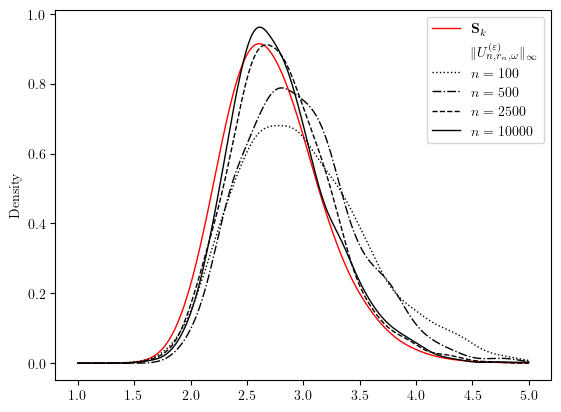

In [34]:
plt.rcParams['lines.linewidth'] = 1
den_est_GP=gaussian_kde(sups_GP_uni,bw_method=n_sups**(-1/5))
t = np.linspace(1, 5, 1000)
f_GP = den_est_GP(t)
plt.plot(t, f_GP,c='r',label=r'$\mathbf{S}_{k}$')
custom_entry = Line2D([0], [0], color='white', label=r'$ \Vert U_{n,r_{n},\omega}^{(\varepsilon)}\Vert_{\infty}  $ ')
styles=['dotted','dashdot','dashed','solid']
for i in range(len(n_choices)):
    n_s=n_choices[i]
    den_est_U=gaussian_kde(sup_arr[i],bw_method=n_sups**(-1/5))
    f_U = den_est_U(t)
    plt.plot(t, f_U, c='k', linestyle=styles[i], label=r'for $n='+f'{str(n_s)}'+r'$')
plt.ylabel('Density')
plt.legend(handles=  [plt.Line2D([0], [0], color='r', lw=1, label=r'$\mathbf{S}_{k}$')] + [custom_entry] +
                    [plt.Line2D([0], [0], color='k', lw=1, linestyle=style, label=r'$n='+f'{str(n_s)}'+r'$') for style, n_s in zip(styles, n_choices)])
plt.savefig(fname="plots/densities.pdf")

In [37]:
# kol smirnov und cramer von mises distances for the distributions
ks_dist=[]
for i in range(len(n_choices)):
    test=stats.kstest(sups_GP_uni,sup_arr[i])
    ks_dist.append(test.statistic)

cvm_dist=[]
for i in range(len(n_choices)):
    test=stats.cramervonmises_2samp(sups_GP_uni,sup_arr[i])
    cvm_dist.append(test.statistic)
ks_dist, cvm_dist

([np.float64(0.20447999999999994),
  np.float64(0.18843),
  np.float64(0.07846000000000003),
  np.float64(0.06298000000000004)],
 [np.float64(19.47951592148513),
  np.float64(18.778993073663287),
  np.float64(2.8856973013861307),
  np.float64(1.4847444967326737)])

### Heatmaps

In [19]:
n_samples=8000

In [20]:
seed=98765432

model_uni=RandomForestModel(n_trees=n_trees, max_depth=k,sample_size_fct=r,tree_type="Uni")
model_ehr=RandomForestModel(n_trees=n_trees, max_depth=k,sample_size_fct=r,tree_type="Ehr",delta=delta,B=B)
model_histo=HistogramEstimator(n_cells=n_h) 
model_histo_fine=HistogramEstimator(n_cells=2**k) 

#data
np.random.seed(seed)
e = np.random.normal(size=n_samples)
X = np.random.rand(n_samples,p)

m = regression_fct(X)
Y=m+e

X_test=fcts.test_grid(p,k)
X_test_histo=fcts.test_grid(p,n_g=n_h)
m_true_grid=regression_fct(X_test)

model_uni.train(X,Y)
model_ehr.train(X,Y)
model_histo.train(X,Y)
model_histo_fine.train(X,Y)

preds_uni=model_uni.predict(X_test)
preds_ehr=model_ehr.predict(X_test)
preds_histo=model_histo.predict(X_test_histo)   
data_pred=model_histo_fine.predict(X_test)

vmin_d = np.nanmin(data_pred)
vmax_d = np.nanmax(data_pred)
all_preds = np.concatenate([preds_uni.flatten(), preds_histo.flatten(), m_true_grid.flatten()])
vmin_p = np.nanmin(all_preds)
vmax_p = np.nanmax(all_preds)

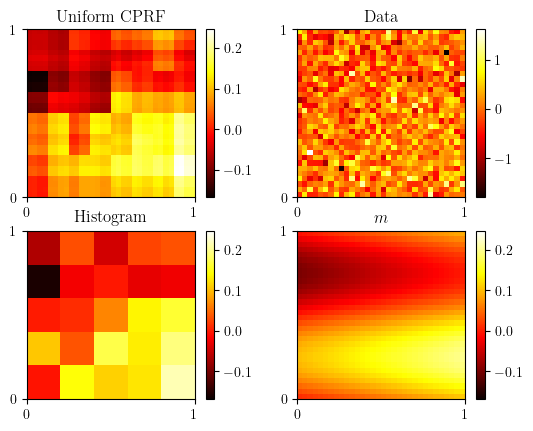

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
c1 = ax1.imshow(preds_uni.reshape((2**k,2**k)), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=vmin_p, vmax=vmax_p)
c2 = ax2.imshow(data_pred.reshape((2**k,2**k)), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=vmin_d, vmax=vmax_d)
c3 = ax3.imshow(preds_histo.reshape((n_h,n_h)), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=vmin_p, vmax=vmax_p)
c4 = ax4.imshow(m_true_grid.reshape((2**k,2**k)), cmap='hot', origin='lower', extent=[0, 1, 0, 1], vmin=vmin_p, vmax=vmax_p)

# axis ticks
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
# color bars
cbar1 = fig.colorbar(c1, ax=ax1, orientation='vertical')
cbar2 = fig.colorbar(c2, ax=ax2, orientation='vertical')
cbar3 = fig.colorbar(c3, ax=ax3, orientation='vertical')
cbar4 = fig.colorbar(c4, ax=ax4, orientation='vertical')

ax1.set_title('Uniform CPRF')
ax2.set_title('Data')
ax3.set_title('Histogram')
ax4.set_title('$m$')

fig.savefig(fname="plots/heat_maps.pdf")
plt.show()

### Scatter plot

In [22]:
# training sample size
n_samples = 2000 #4000

#factor for subsample size
r = 0.75  

# asymptotic standard deviations (pointwise)
as_std_uni=np.sqrt(2**(2*k)*V_cap_uni/n_samples)
as_std_ehr=np.sqrt(2**(2*k)*V_cap_ehr/n_samples)
as_std_histo=np.sqrt(n_h**p/n_samples)

#confidence band radii based on the quantiles and the standard deviations
cb_rad_uni=as_std_uni*quants_uni
cb_rad_ehr=as_std_ehr*quants_ehr
cb_rad_histo=as_std_histo*quants_histo

print("Confidence band radii for confidence levels :", 1-beta)
print("Uniform CPRF:   ",cb_rad_uni)
print("Ehrenfest CPRF: ", cb_rad_ehr)
print("Histogram:      ", cb_rad_histo)

Confidence band radii for confidence levels : [0.9  0.95 0.99]
Uniform CPRF:    [0.30398994 0.3236634  0.36328155]
Ehrenfest CPRF:  [0.31432011 0.3356703  0.3767562 ]
Histogram:       [0.32009104 0.3447311  0.39502461]


In [29]:
#grid for error realization
eps=1/2**20
g=2**k2
splits=np.linspace(0, 1, num=g, endpoint=False)
xl=splits+eps
xr=splits+1/g-eps
axis_grid=np.sort(np.concatenate((xl,xr)))
prod=list(itertools.product(axis_grid, repeat=p))
grid=np.array(prod)
grid.shape

(1024, 2)

In [31]:
seed=99999
# n_tests CBs
sig=1
cover_num=np.zeros(3)
test_sups=[]
n_tests=10
model_uni=RandomForestModel(n_trees=n_trees, max_depth=k,sample_size_fct=r,tree_type="Uni")

X_test=grid
m_true_grid=regression_fct(X_test)

np.random.seed(seed)
errors=np.empty((2**(k*p),n_tests))
for i in range(n_tests):
    e = np.random.normal(0,sig,n_samples)
    X = np.random.rand(n_samples,p)
    m = regression_fct(X)
    Y=m+e
    model_uni.clear()
    model_uni.train(X,Y)

    preds=model_uni.predict(X_test)
    error=preds-m_true_grid
    errors[:,i]=error
    sup=np.max(abs(error))
    test_sups.append(sup)
#cover_num=np.sum(test_sups<cb_rad_uni*sig)
for j in range(3):
    cover_num[j]=sum(np.array(test_sups)<sig*cb_rad_uni[j])
cover_num

array([8., 9., 9.])

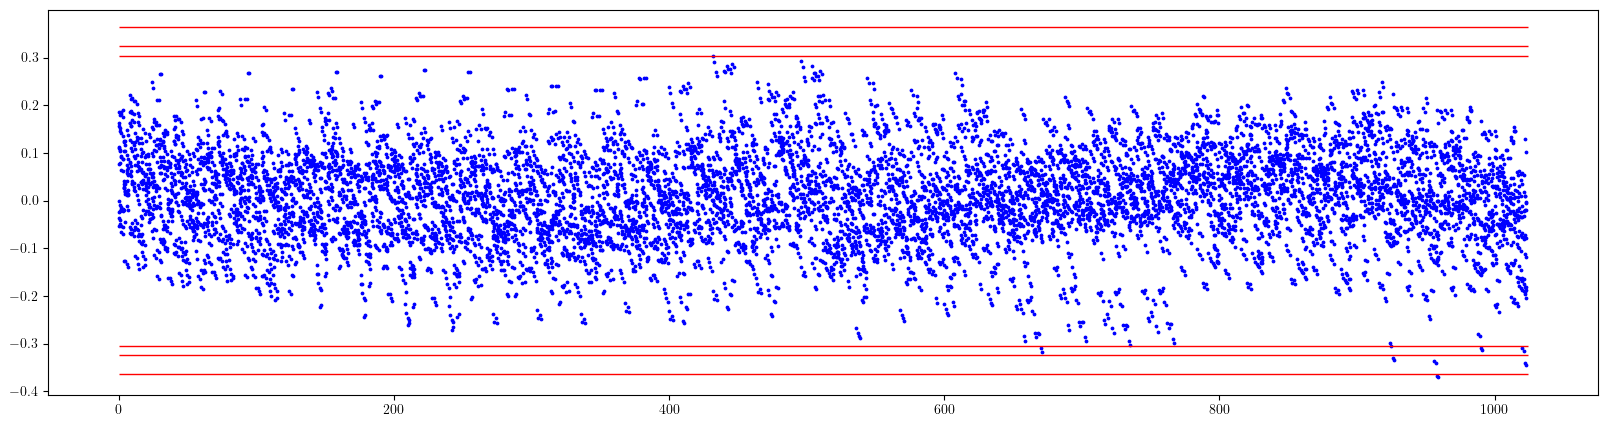

In [32]:
plt.rcParams['lines.linewidth'] = 1
n_x=2**(k*p)
cb_rad_lines=np.array((cb_rad_uni*sig,-cb_rad_uni*sig))
x_plot=np.arange(n_x)
plt.figure(figsize=(20, 5)) # width=10, height=5
for i in range(n_x):
    plt.scatter(np.ones(n_tests)*i,errors[i,:],color='b',s=3)
plt.hlines(cb_rad_lines,color='r',xmin=0,xmax=n_x)
plt.savefig(fname="plots/scatter1.pdf")
plt.show()

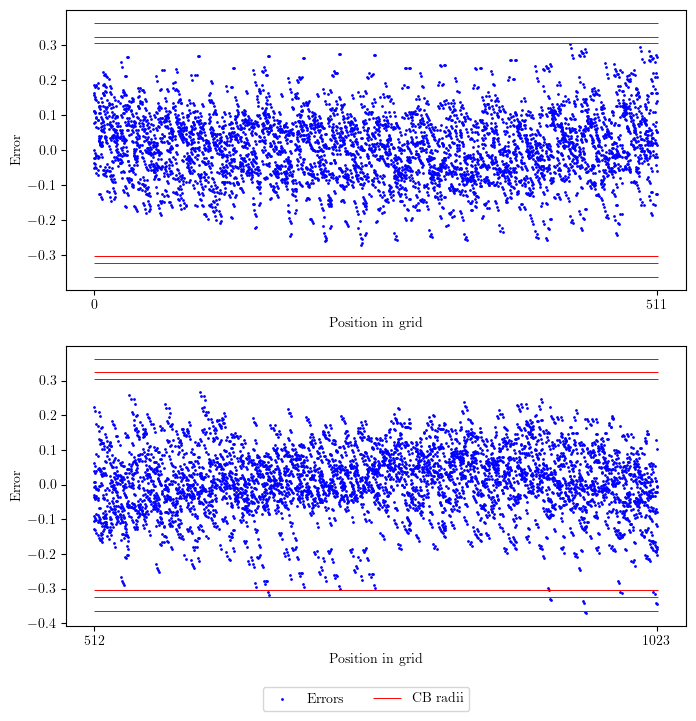

In [37]:
plt.rcParams['lines.linewidth'] = 0.7
n_x=2**(k*p)
n_x_half=2**(k*p-1)
cb_rad_lines=np.array((cb_rad_uni*sig,-cb_rad_uni*sig))
x_plot=np.arange(n_x)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

for i in range(n_x_half):
    if i == 0:
        ax1.scatter(np.ones(n_tests) * i, errors[i, :], color='b', s=1, label="Errors")
    else:
        ax1.scatter(np.ones(n_tests) * i, errors[i, :], color='b', s=1)
ax1.hlines(cb_rad_lines,color='r',xmin=0,xmax=n_x_half,label='CB radii')
ax1.set_ylabel('Error')
ax1.set_xlabel('Position in grid')
ax1.set_xticks([0,511])

for i in range(n_x_half):
    ax2.scatter(np.ones(n_tests)*(i+n_x_half),errors[i+n_x_half,:],color='b',s=1)
ax2.hlines(cb_rad_lines,color='r',xmin=n_x_half,xmax=n_x)
ax2.set_ylabel('Error')
ax2.set_xlabel('Position in grid')
ax2.set_xticks([512,1023])
handles, labels = ax1.get_legend_handles_labels()  # get handles
fig.legend(handles, labels, loc='lower center',ncol=2, bbox_to_anchor=(0.5, -0.005))
plt.show()
fig.savefig(fname="plots/scatter2.pdf")

### Result plots

In [4]:
plt.rcParams['lines.linewidth'] = 0.7

#### $n$ variation

In [5]:
# define theoretical coverage
theoretical_coverage = np.array([0.9, 0.95, 0.99])

# def sample size n and tree depth k
sample_sizes = [250, 500, 1000, 2000, 4000, 8000]
k_values = [5, 6]  # k = 5 und k = 6

# dimensions: coverage/rad (2), uni/ehr (2), k (2), sample size (6), theoretical coverage (3) 
rf_results = np.zeros((2, 2, len(k_values), len(sample_sizes), len(theoretical_coverage)))

# Data for k=5
uniform_numbers_k5 = [
    [676, 778, 916],
    [759, 852, 954],
    [802, 878, 963],
    [748, 870, 965],
    [658, 797, 947],
    [450, 640, 873],
]

ehrenfest_numbers_k5 = [
    [668, 781, 909],
    [770, 856, 946],
    [805, 889, 964],
    [754, 866, 966],
    [674, 809, 946],
    [463, 639, 877],
]

uniform_radii_k5 = [
    [0.85931137, 0.91492383, 1.02691545],
    [0.60816429, 0.64752315, 0.72678348],
    [0.4300588, 0.45789112, 0.51393946],
    [0.30392004, 0.32358897, 0.36319801],
    [0.21489386, 0.22880124, 0.25680775],
    [0.15197627, 0.16181179, 0.18161843],
]

ehrenfest_radii_k5 = [
    [0.88851245, 0.94886465, 1.06500527],
    [0.6288309, 0.67154424, 0.75374096],
    [0.44467304, 0.47487745, 0.53300224],
    [0.31424783, 0.33559312, 0.37666957],
    [0.22219637, 0.23728906, 0.26633313],
    [0.15714072, 0.1678145, 0.18835492],
]

# data k=6
uniform_numbers_k6 = [
    [599, 712, 877],
    [611, 756, 901],
    [778, 867, 962],
    [786, 881, 967],
    [814, 898, 967],
    [763, 856, 967],
]

ehrenfest_numbers_k6 = [
    [627, 733, 897],
    [629, 759, 903],
    [760, 870, 955],
    [806, 887, 969],
    [813, 897, 968],
    [756, 870, 966],
]

uniform_radii_k6 = [
    [1.28007368, 1.35061883, 1.49543394],
    [0.90595229, 0.95587952, 1.05837017],
    [0.64063733, 0.675943, 0.74841849],
    [0.45273466, 0.47768497, 0.52890297],
    [0.32011676, 0.33775846, 0.37397336],
    [0.22639154, 0.23886802, 0.26447976],
]

ehrenfest_radii_k6 = [
    [1.33327216, 1.40820134, 1.56534969],
    [0.94360268, 0.99663265, 1.10785196],
    [0.66726153, 0.70476127, 0.78340916],
    [0.47154982, 0.49805067, 0.55363068],
    [0.33342046, 0.35215852, 0.39145767],
    [0.23580012, 0.24905196, 0.27684494],
]

In [6]:
# save values in Numpy-array
# dimensions: coverage/rad (2), uni/ehr (2), k (2), sample size (6), theoretical coverage (3)
for idx, sample_size in enumerate(sample_sizes):
    for t_idx, t in enumerate(theoretical_coverage):
        # k=5
        rf_results[0, 0, 0, idx, t_idx] = uniform_numbers_k5[idx][t_idx] / 1000  # Coverage
        rf_results[1, 0, 0, idx, t_idx] = uniform_radii_k5[idx][t_idx]  # Radius

        rf_results[0, 1, 0, idx, t_idx] = ehrenfest_numbers_k5[idx][t_idx] / 1000  # Coverage
        rf_results[1, 1, 0, idx, t_idx] = ehrenfest_radii_k5[idx][t_idx]  # Radius

        # k=6
        rf_results[0, 0, 1, idx, t_idx] = uniform_numbers_k6[idx][t_idx] / 1000  # Coverage 
        rf_results[1, 0, 1, idx, t_idx] = uniform_radii_k6[idx][t_idx]  # Radius

        rf_results[0, 1, 1, idx, t_idx] = ehrenfest_numbers_k6[idx][t_idx] / 1000  # Coverage
        rf_results[1, 1, 1, idx, t_idx] = ehrenfest_radii_k6[idx][t_idx]  # Radius

# results
rf_results[0,0,0,:,2]

array([0.916, 0.954, 0.963, 0.965, 0.947, 0.873])

In [7]:
# results histogram
# theoretical cov
theoretical_coverage = np.array([0.9, 0.95, 0.99])

# Def sample sizes and n_h values
sample_sizes = [250, 500, 1000, 2000, 4000, 8000]
n_h_values = [5, 7]  # n_h = 5 und n_h = 7

# Dim: cov(rad (2), n_h (2), sample size (6), theoretical coverage (3)
histo_results = np.zeros((2, len(n_h_values), len(sample_sizes), len(theoretical_coverage)))

# data n_h=5
numbers_nh5 = [
    [678, 788, 910],
    [721, 823, 939],
    [737, 854, 948],
    [660, 793, 933],
    [492, 664, 898],
    [228, 400, 773],
]

radii_nh5 = [
    [0.90482556, 0.9744775, 1.11664598],
    [0.64037625, 0.68967133, 0.79028887],
    [0.45283724, 0.48769589, 0.55884682],
    [0.32001743, 0.34465183, 0.39493378],
    [0.2262759, 0.24369423, 0.27924728],
    [0.16002583, 0.17234434, 0.19748801],
]

# data n_h=7
numbers_nh7 = [
    [324, 405, 562],
    [643, 744, 870],
    [708, 827, 946],
    [733, 852, 959],
    [711, 839, 953],
    [605, 750, 940],
]

radii_nh7 = [
    [1.3578776, 1.4502873, 1.63976815],
    [0.96101681, 1.02641834, 1.16052047],
    [0.67957579, 0.725824, 0.82065331],
    [0.48025224, 0.51293557, 0.57995089],
    [0.33957371, 0.36268324, 0.41006801],
    [0.2401518, 0.25649521, 0.29000645],
]

# save in Numpy-Array
for nh_idx, n_h in enumerate(n_h_values):
    for idx, sample_size in enumerate(sample_sizes):
        
        for t_idx, t in enumerate(theoretical_coverage):
            if n_h == 5:
                histo_results[0, nh_idx, idx, t_idx] = numbers_nh5[idx][t_idx] / 1000  # Coverage 
                histo_results[1, nh_idx, idx, t_idx] = radii_nh5[idx][t_idx] 
            elif n_h == 7:
                histo_results[0, nh_idx, idx, t_idx] = numbers_nh7[idx][t_idx] / 1000  # Coverage 
                histo_results[1, nh_idx, idx, t_idx] = radii_nh7[idx][t_idx]

#print(histo_results)

In [8]:
histo_results[1,0,:,2]

array([1.11664598, 0.79028887, 0.55884682, 0.39493378, 0.27924728,
       0.19748801])

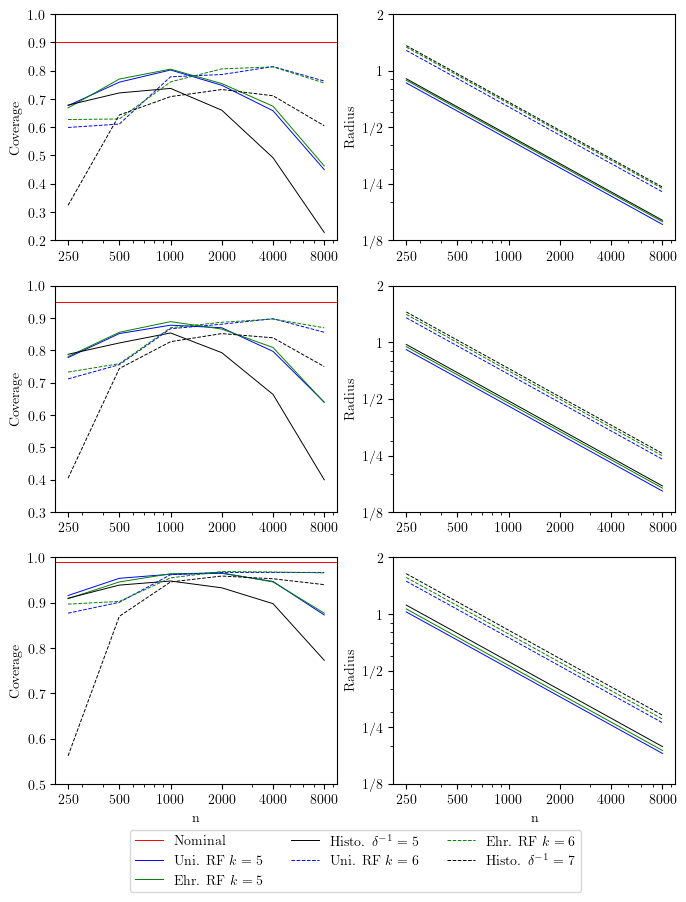

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(8,10))
names=[r'Uni. RF $k=5$', r'Ehr. RF $k=5$', r'Histo. $\delta^{-1}=5$',  r'Uni. RF $k=6$',  r'Ehr. RF $k=6$', r'Histo. $\delta^{-1}=7$']
styles=['solid','dashed']
rad_ticks=[0.125,0.25,0.5,1,2]
#tick_labels = ['$2^{-3}$','$2^{-2}$','$2^{-1}$','$2^{0}$','$2^{1}$']
tick_labels = ['$1/8$','$1/4$','$1/2$','$1$','$2$']


for i in range(3):
    axs[i,0].axhline(y=1-beta[i],color='r',label='Nominal')
    for j in range(2):
        #coverages
        axs[i,0].plot(sample_sizes, rf_results[0,0,j,:,i],c='b',linestyle=styles[j],label=str(names[j*3])) #uni
        axs[i,0].plot(sample_sizes, rf_results[0,1,j,:,i],c='g',linestyle=styles[j],label=str(names[j*3+1])) #ehr
        axs[i,0].plot(sample_sizes, histo_results[0,j,:,i],c='k',linestyle=styles[j],label=str(names[j*3+2])) #histo

        #radii
        axs[i,1].plot(sample_sizes, rf_results[1,0,j,:,i],c='b',linestyle=styles[j],label=str(names[j*3])) #uni
        axs[i,1].plot(sample_sizes, rf_results[1,1,j,:,i],c='g',linestyle=styles[j],label=str(names[j*3+1])) #ehr
        axs[i,1].plot(sample_sizes, histo_results[1,j,:,i],c='k',linestyle=styles[j],label=str(names[j*3+2])) #histo            
    
    #plt.ylim(0.4,1)
    axs[i,0].set_xscale('log')
    #plt.title('Coverage comparison')
    #axs[i,0].set_xlabel('n')
    axs[i,0].set_ylabel('Coverage')
    #axs[i,0].legend()

    #axs[i,1].set_xlabel('n')
    axs[i,1].set_yscale('log')
    axs[i,1].set_xscale('log')
    axs[i,1].set_ylabel('Radius')
    axs[i,1].set_yticks(rad_ticks) 
    axs[i,1].set_yticklabels(tick_labels)
    #axs[i,1].get_yaxis().set_major_formatter(plt.ScalarFormatter())

axs[2,0].set_xlabel('n')
axs[2,1].set_xlabel('n')
#ax.set_yticks([0.25, 0.5, 1])
#ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    
axs[0, 0].set_ylim(0.2, 1)
axs[1, 0].set_ylim(0.3, 1)
axs[2, 0].set_ylim(0.5, 1)
for ax in axs.flat:
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
handles, labels = axs[0, 0].get_legend_handles_labels()  # Holen Sie sich Handles und Labels von einem der Subplots
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.005))
#fig.legend()
fig.savefig(fname="plots/coverages_radii_n_variation.pdf")

#### Sigma variation for $p=2$ and $p=4$

In [14]:
# Sigma-values
sigma_values = [0.5, 0.75, 1.0, 1.25]

# values p = 2
coverage_uni_p2 = [
    [0.416, 0.616, 0.849],  # sigma = 0.5
    [0.656, 0.782, 0.941],  # sigma = 0.75
    [0.734, 0.839, 0.961],  # sigma = 1.0
    [0.777, 0.871, 0.969]   # sigma = 1.25
]

coverage_ehr_p2 = [
    [0.416, 0.598, 0.868],  # sigma = 0.5
    [0.648, 0.809, 0.945],  # sigma = 0.75
    [0.745, 0.866, 0.970],  # sigma = 1.0
    [0.790, 0.888, 0.973]   # sigma = 1.25
]

radius_uni_p2 = [
    [0.15197087, 0.16180604, 0.18161198],  # sigma = 0.5
    [0.22794422, 0.24269619, 0.27240351],  # sigma = 0.75
    [0.30392004, 0.32358897, 0.36319801],  # sigma = 1.0
    [0.37989685, 0.40448282, 0.4539937 ]   # sigma = 1.25
]

radius_ehr_p2 = [
    [0.15713514, 0.16780854, 0.18834824],  # sigma = 0.5
    [0.23569021, 0.25169946, 0.28250736],  # sigma = 0.75
    [0.31424783, 0.33559312, 0.37666957],  # sigma = 1.0
    [0.39280649, 0.41948787, 0.470833]     # sigma = 1.25
]

# p = 4
coverage_uni_p4 = [
    [0.002, 0.006, 0.041],  # sigma = 0.5
    [0.065, 0.116, 0.359],  # sigma = 0.75
    [0.188, 0.321, 0.607],  # sigma = 1.0
    [0.320, 0.469, 0.747]   # sigma = 1.25
]

coverage_ehr_p4 = [
    [0.001, 0.004, 0.046],  # sigma = 0.5
    [0.056, 0.132, 0.382],  # sigma = 0.75
    [0.202, 0.345, 0.635],  # sigma = 1.0
    [0.338, 0.502, 0.742]   # sigma = 1.25
]

radius_uni_p4 = [
    [0.12418579, 0.13124392, 0.14573721],  # sigma = 0.5
    [0.18626599, 0.19685248, 0.21859092],  # sigma = 0.75
    [0.24834832, 0.26246327, 0.29144712],  # sigma = 1.0
    [0.31043149, 0.32807496, 0.36430432]   # sigma = 1.25
]

radius_ehr_p4 = [
    [0.12614492, 0.13348832, 0.14854292],  # sigma = 0.5
    [0.1892045, 0.20021884, 0.2227992],    # sigma = 0.75
    [0.25226622, 0.26695163, 0.29705802],  # sigma = 1.0
    [0.31532881, 0.33368534, 0.37131785]   # sigma = 1.25
]

In [15]:
# Numpy Arrays (Coverage/Radii, Uni/Ehr, Sigma, 1-\beta
data_array_p2 = np.zeros((2, 2, 4, 3))  # (Coverage/Radius, Uni/Ehr, Sigma, values)
data_array_p4 = np.zeros((2, 2, 4, 3))  # (Coverage/Radius, Uni/Ehr, Sigma, values)

# Fill array p = 2
data_array_p2[1, 0, :, :] = radius_uni_p2  # Uni Radius
data_array_p2[1, 1, :, :] = radius_ehr_p2  # Ehr Radius
data_array_p2[0, 0, :, :] = coverage_uni_p2  # Uni Coverage
data_array_p2[0, 1, :, :] = coverage_ehr_p2  # Ehr Coverage

# Fill Array p = 4
data_array_p4[1, 0, :, :] = radius_uni_p4  # Uni Radius p=4
data_array_p4[1, 1, :, :] = radius_ehr_p4  # Ehr Radius p=4
data_array_p4[0, 0, :, :] = coverage_uni_p4  # Uni Coverage p=4
data_array_p4[0, 1, :, :] = coverage_ehr_p4  # Ehr Coverage p=4

#print( data_array_p4)

In [16]:
data_array_p2[1,0,:,1]

array([0.16180604, 0.24269619, 0.32358897, 0.40448282])

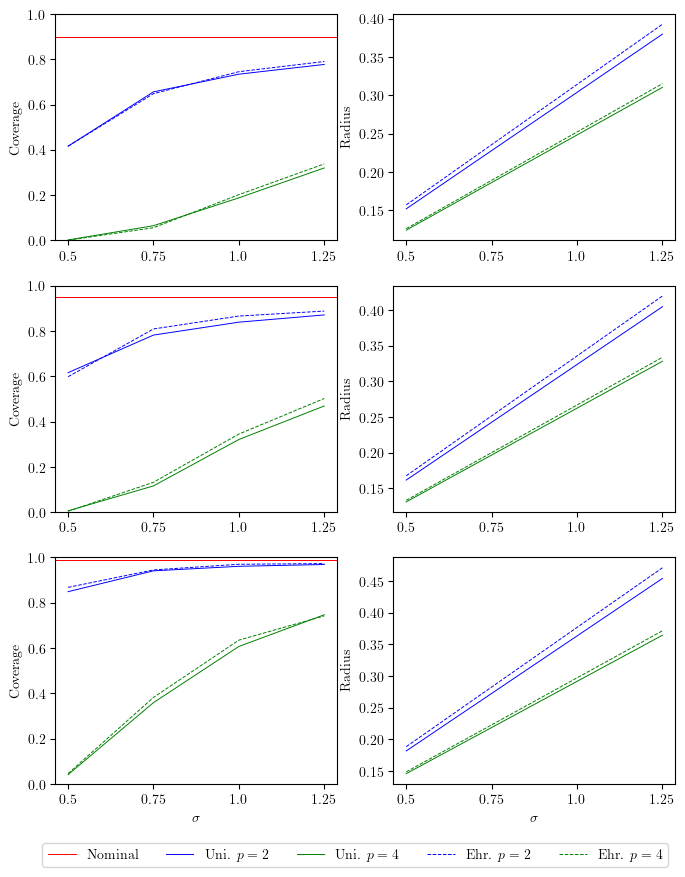

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(8,10))
names=['Uni.','Ehr.']
colors=['b','g']
styles=['solid','dashed']#,'dotted']

#i for 90,95,99
#j for uni,ehr
for i in range(3):
    axs[i,0].axhline(y=1-beta[i],color='r',label='Nominal')
    for j in range(2):
        axs[i,0].plot(sigma_values, data_array_p2[0,j,:,i], label=names[j]+' $p=2$', c='b',linestyle=styles[j])
        axs[i,1].plot(sigma_values, data_array_p2[1,j,:,i], label=names[j]+' $p=2$', c='b',linestyle=styles[j])
        axs[i,0].plot(sigma_values, data_array_p4[0,j,:,i], label=names[j]+' $p=4$', c='g',linestyle=styles[j])
        axs[i,1].plot(sigma_values, data_array_p4[1,j,:,i], label=names[j]+' $p=4$', c='g',linestyle=styles[j])

    axs[i,0].axhline(y=1-beta[i],color='r')
    axs[i,0].set_ylabel('Coverage')
    axs[i,1].set_ylabel('Radius')

axs[2,0].set_xlabel(r'$\sigma$')
axs[2,1].set_xlabel(r'$\sigma$')
    
axs[0, 0].set_ylim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[2, 0].set_ylim(0, 1)

for ax in axs.flat:
    ax.set_xticks(sigma_values)
    ax.set_xticklabels(sigma_values)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=5,bbox_to_anchor=(0.5, 0.02))
fig.savefig(fname="plots/coverages_radii_p_sig_variation.pdf")